In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import re
import pickle
from tqdm import tqdm
import nltk # Natural Language ToolKit
from gensim import corpora # Dictionaries
from nltk.stem import PorterStemmer # Porter stemming
from gensim.models import TfidfModel # TF-IDF models
from gensim import similarities # Similarity computations
from sklearn.cluster import KMeans
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
import json
%matplotlib inline
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Application :<b>Clustering books based on their description

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
books_df = pd.read_csv('/content/Books_seperate.csv')
print('Shape of Dataset: ',books_df.shape)
books_df.head()

Shape of Dataset:  (1250, 14)


,publication_date,euro_price,type,category,name,subtitle,author,isSecondHand,publisher,language,no_of_pages,weight,salesRank,short_blurb
0,20-Aug-20,9.60,Paperback,history,The Royal Netherlands Navy of World War II,NaN,"Ryan Noppen, Paul Wright (illustrator)",False,Bloomsbury Publishing (UK),English,48,5.0,25358.0,"In the late 19th and early 20th century, a com..."
1,21-Jan-20,2.90,Paperback,literature,Fascism and Democracy,NaN,George Orwell (author),False,Penguin Books Ltd,English,48,5.6,2852.0,'Fascism and Democracy' collects five brillian...
2,5-Nov-20,10.77,Paperback,fiction,Interior Chinatown,A Novel,Charles Yu (author),False,Europa Editions (UK) Ltd.,English,288,10.0,839.0,"A deeply personal novel about race, pop cultur..."
3,9-Nov-20,12.92,Paperback,artanddesign,Railroad Depots of Northwest Pennsylvania,NaN,Dan West (author),False,Arcadia Publishing,English,128,16.0,3965.0,From 1860 until the decline of the railroads n...
4,9-Nov-20,12.92,Paperback,sports,Lost Ski Areas of Tahoe and Donner,NaN,Ingrid P. Wicken (author),False,Arcadia Publishing,English,192,19.0,3371.0,"At the beginning of the twentieth century, Lak..."


For clustering books based on description, we need to remove from short description
1. All non alpha-numeric characters
2. Null description rows
3. Empty Description rows
4. HTML tags
5. Punctuations
6. Stopwords

In [ ]:
books_df['short_blurb'] = books_df['short_blurb'].str.replace(r'[\W_]+', ' ')
books_df = books_df[books_df['short_blurb'].notnull()]
books_df = books_df[-(books_df['short_blurb'] == ' ')]
books_df.shape

(1214, 14)

Split string into words

In [ ]:
books_df['book_desc_split'] = books_df['short_blurb'].str.split()
books_df['book_desc_split'].head()

0    [In, the, late, 19th, and, early, 20th, centur...
1    [Fascism, and, Democracy, collects, five, bril...
2    [A, deeply, personal, novel, about, race, pop,...
3    [From, 1860, until, the, decline, of, the, rai...
4    [At, the, beginning, of, the, twentieth, centu...
Name: book_desc_split, dtype: object

Convert tokens to lowercase

In [ ]:
books_df['book_desc_split'] = books_df.progress_apply(lambda row: [token.lower() for token in row['book_desc_split']] , 
                                          axis=1)
books_df[['book_desc_split']].head()

100%|██████████| 1214/1214 [00:00<00:00, 7078.83it/s]


,book_desc_split
0,"[in, the, late, 19th, and, early, 20th, centur..."
1,"[fascism, and, democracy, collects, five, bril..."
2,"[a, deeply, personal, novel, about, race, pop,..."
3,"[from, 1860, until, the, decline, of, the, rai..."
4,"[at, the, beginning, of, the, twentieth, centu..."


In [ ]:
#removing HTML tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [ ]:
books_df['book_desc_split'] = books_df.progress_apply(lambda row: [remove_html(token) for token in row['book_desc_split']] , 
                                          axis=1)
books_df['book_desc_split'].head()

100%|██████████| 1214/1214 [00:00<00:00, 11990.84it/s]


0    [in, the, late, 19th, and, early, 20th, centur...
1    [fascism, and, democracy, collects, five, bril...
2    [a, deeply, personal, novel, about, race, pop,...
3    [from, 1860, until, the, decline, of, the, rai...
4    [at, the, beginning, of, the, twentieth, centu...
Name: book_desc_split, dtype: object

In [ ]:
books_df['book_desc_split'] = books_df.progress_apply(lambda row: [re.sub(r'\W+', '', token) for token in row['book_desc_split']], axis=1)
books_df['book_desc_split'].head()

100%|██████████| 1214/1214 [00:00<00:00, 10165.37it/s]


0    [in, the, late, 19th, and, early, 20th, centur...
1    [fascism, and, democracy, collects, five, bril...
2    [a, deeply, personal, novel, about, race, pop,...
3    [from, 1860, until, the, decline, of, the, rai...
4    [at, the, beginning, of, the, twentieth, centu...
Name: book_desc_split, dtype: object

In [ ]:
# Getting the English stop words from nltk
stopwords = nltk.corpus.stopwords.words('english')
books_df['book_desc_split'] = books_df.progress_apply(lambda row: [token for token in row['book_desc_split'] 
                                                       if token not in stopwords] , 
                                          axis=1)
books_df[['book_desc_split']].head()

100%|██████████| 1214/1214 [00:00<00:00, 7020.23it/s]


,book_desc_split
0,"[late, 19th, early, 20th, century, combination..."
1,"[fascism, democracy, collects, five, brilliant..."
2,"[deeply, personal, novel, race, pop, culture, ..."
3,"[1860, decline, railroads, nearly, 100, years,..."
4,"[beginning, twentieth, century, lake, tahoe, d..."


Token -> Stem

In [ ]:
porter = PorterStemmer()
books_df['book_desc_split'] = books_df.progress_apply(lambda row: [porter.stem(token) for token in row['book_desc_split']] , 
                                          axis=1)
books_df[['book_desc_split']].head()

100%|██████████| 1214/1214 [00:01<00:00, 990.29it/s]


,book_desc_split
0,"[late, 19th, earli, 20th, centuri, combin, coa..."
1,"[fascism, democraci, collect, five, brilliant,..."
2,"[deepli, person, novel, race, pop, cultur, esc..."
3,"[1860, declin, railroad, nearli, 100, year, la..."
4,"[begin, twentieth, centuri, lake, taho, donner..."


Vectrorizing Token

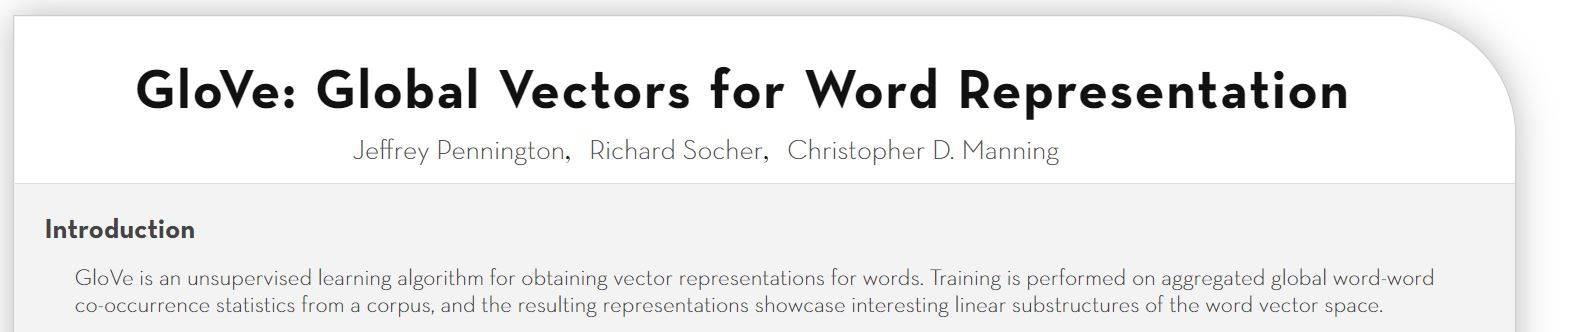

In [ ]:
with open('/content/drive/MyDrive/glove.840B.300d.pkl/glove.840B.300d.pkl', 'rb') as f:
    model = pickle.load(f,encoding = "ISO-8859-1")
    glove_words = set(model.keys())

In [ ]:
w2v_desc = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(books_df['book_desc_split'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    for word in sentence: # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
    w2v_desc.append(vector)

100%|██████████| 1214/1214 [00:00<00:00, 6431.79it/s]


K-Means Hyperparameter Tuning

In [ ]:
print("Number of known categories = ",len(books_df['category'].unique()))

Number of known categories =  27


In [ ]:
loss = []
for k in tqdm(range(3,35)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(list(w2v_desc))
    loss.append(kmeans.inertia_)

100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


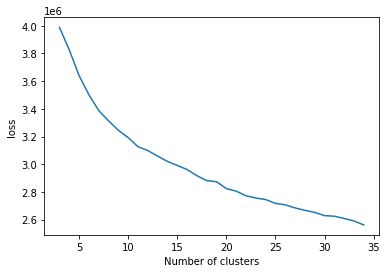

In [ ]:
plt.figure()
plt.plot(range(3,35),loss)
plt.xlabel("Number of clusters")
plt.ylabel("loss")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=18)
kmeans.fit(list(w2v_desc))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Data Matrix to store Clusters

In [ ]:
datadict = {}
datadict['title'] = books_df['name']
datadict['author'] = books_df['author']
datadict['vectors'] = w2v_desc

In [ ]:
data1 = pd.DataFrame(datadict)
data1.head(20)

,title,author,vectors
0,The Royal Netherlands Navy of World War II,"Ryan Noppen, Paul Wright (illustrator)","[7.446045182645321, -6.612745354883373, 7.8881..."
1,Fascism and Democracy,George Orwell (author),"[-0.9758202197263017, 2.721654836088419, -0.88..."
2,Interior Chinatown,Charles Yu (author),"[2.701486011967063, 2.731433615088463, 0.05646..."
3,Railroad Depots of Northwest Pennsylvania,Dan West (author),"[18.998997207032517, 3.5326467955019325, 3.122..."
4,Lost Ski Areas of Tahoe and Donner,Ingrid P. Wicken (author),"[20.920971296727657, 1.3233332785312086, 4.163..."
5,Colorado's Daring Ivy Baldwin,Dr. Jack Stokes Ballard (author),"[7.894896904472262, -1.159395746421069, 2.7348..."
6,"K2, the Savage Mountain","Charles S. Houston (author), Robert H. Bates (...","[-0.849902605637908, 1.7754900306463242, 2.218..."
7,Politics and the English Language,George Orwell (author),"[0.30705196945928037, -0.5409900397062302, 2.2..."
8,Essential Clinical Skills,Susan Carlisle,"[2.72229297272861, 0.04923300817608833, -0.880..."
9,Harry Potter,Insight Editions,"[1.0643124040216208, -0.7008690896909684, 0.99..."


Group Books into Clusters

In [ ]:
clusters = []
for i in data1['vectors']:
    clusters.append(kmeans.predict(i.reshape(1, -1))[0])

In [ ]:
data1['clusters'] = clusters
data1['predetermined_category'] = books_df['category']

In [ ]:
data1[data1['clusters']==1].tail()

,title,author,vectors,clusters,predetermined_category
1079,Glastonbury 50,"Michael Eavis (author), Emily Eavis (author)","[9.108836023602635, 8.31714609102346, 6.001531...",1,music
1080,Royal Albert Hall,Royal Albert Hall (associated with work),"[4.6905067805200815, 3.350005256012082, 2.8961...",1,music
1100,No Such Thing As Forever,Paolo Brillo (photographer),"[3.5603083055466413, 14.090218607423594, 0.913...",1,music
1241,St. Moritz Chic,Dora Lardelli (author),"[15.31559757143259, 5.760751436377177, 7.89700...",1,travel
1246,Palm Beach,Aerin Lauder (author),"[12.871418798342347, 4.3620630241930485, 2.201...",1,travel


In [ ]:
for i in range(0,18):
  print("Cluster",i,"=",data1[data1['clusters']==i].shape[0])

Cluster 0 = 180
Cluster 1 = 54
Cluster 2 = 57
Cluster 3 = 350
Cluster 4 = 14
Cluster 5 = 1
Cluster 6 = 1
Cluster 7 = 45
Cluster 8 = 2
Cluster 9 = 30
Cluster 10 = 65
Cluster 11 = 1
Cluster 12 = 27
Cluster 13 = 170
Cluster 14 = 77
Cluster 15 = 70
Cluster 16 = 20
Cluster 17 = 50


In [ ]:
cluster_dict = data1.groupby('clusters').apply(lambda x: x.to_json(orient='records'))

In [ ]:
cluster_dict.to_pickle('clusters.pkl')

In [ ]:
pickle.dump(kmeans, open("clustering_model.pkl", "wb"))

Assign book to Cluster based on short description

In [ ]:
data = pd.read_pickle('./clusters.pkl')

In [ ]:
kmeans_model = pickle.load(open("clustering_model.pkl", "rb"))

<p>Testing model for-<br>
Autobiograph of Benito Mussolini<br><br>
<i>"This volume reprints the Italian dictator's extraordinary comments, capturing the spirit and personality of Il Duce as no other book does.
Included are Mussolini's views on Italian politics, descriptions of his years as an agitator, journalist, and soldier, the formation of the Fascist Party, the "March on Rome," and his early years in power. The text also contains some of his most famous speeches in the Italian Parliament, his vision of Italy's return to glory, and his definitive statement on the doctrine of Fascism and its political justification."</i>


In [ ]:
short_blurb = "This volume reprints the Italian dictator's extraordinary comments, capturing the spirit and personality of Il Duce as no other book does. Included are Mussolini's views on Italian politics, descriptions of his years as an agitator, journalist, and soldier, the formation of the Fascist Party, the 'March on Rome,' and his early years in power. The text also contains some of his most famous speeches in the Italian Parliament, his vision of Italy's return to glory, and his definitive statement on the doctrine of Fascism and its political justification."

In [ ]:
#Preprocessing
short_blurb = short_blurb.replace(r'[\W_]+', ' ')
short_blurb_list = short_blurb.split()
short_blurb_lower = [i.lower() for i in short_blurb_list]
short_blurb_html = [remove_html(token) for token in short_blurb_lower]
short_blurb_punc = [re.sub(r'\W+', '', token) for token in short_blurb_html]

short_blurb_stop = [token for token in short_blurb_punc if token not in stopwords]
short_blurb_stem = [porter.stem(token) for token in short_blurb_stop]

In [ ]:
vector = np.zeros(300) # as word vectors are of zero length
for word in short_blurb_stem: # for each word in a review/sentence
    if word in glove_words:
        vector += model[word]

In [ ]:
prediction = kmeans_model.predict(vector.reshape(1, -1))
print(prediction[0])

17


Cluster 17 is assigned to the book<br>
Cluster 17 contains the following books

In [ ]:
data1[data1['clusters']==17].iloc[-15:-5,:]

,title,author,vectors,clusters,predetermined_category
1075,Prescriber's Guide,Stephen M. Stahl (author),"[2.089078680612147, -3.47223306261003, -2.2819...",17,medical
1117,Economics and Sustainability,Karl Bruckmeier (author),"[-0.2717970162630081, 0.4547705111472169, 3.76...",17,politics
1118,Toward a Coordinated and Balanced Development,"Changchun Cheng, Fenghua Yang, Guanghua Chen (...","[-0.004715814255177975, -1.6968912854790688, 1...",17,politics
1119,"Everyday Boundaries, Borders and Post Conflict...",Renata Summa (author),"[0.9491120390594006, 1.1131771756336093, 0.945...",17,politics
1124,Postcolonial Maghreb and the Limits of IR,Jessica da Silva C. de Oliveira (author),"[2.7490149419754744, -1.7805880159139633, 1.74...",17,politics
1127,Party Proliferation and Political Contestation...,Catherine Lena Kelly (author),"[2.410142979093507, -2.382439042441547, 6.6521...",17,politics
1130,Entrepreneurship and Regional Development,"Rajagopal (editor), Ramesh Behl (editor)","[2.8250471148639917, 0.38853597885463387, 6.48...",17,politics
1132,Expressions of War in Australia and the Pacific,"Amanda Laugesen (editor), Catherine Fisher (ed...","[2.034563535824418, -0.08189499378204346, 6.01...",17,politics
1134,"Communication, Interpreting and Language in Wa...","Amanda Laugesen (editor), Richard Gehrmann (ed...","[4.022366023156792, -3.125300903338939, 6.1998...",17,politics
1146,Globalization,C. Gopinath (author),"[0.3114154466748005, 0.4742220640182495, 0.448...",17,politics


<p>Testing model for-<br>
<b>Harry Potter Chamber of Secrets</b><br><br>
<i>"Harry Potter's summer has included the worst birthday ever, doomy warnings from a house-elf called Dobby, and rescue from the Dursleys by his friend Ron Weasley in a magical flying car! Back at Hogwarts School of Witchcraft and Wizardry for his second year, Harry hears strange whispers echo through empty corridors - and then the attacks start. Students are found as though turned to stone . Dobby's sinister predictions seem to be coming true."</i>


In [ ]:
short_blurb = "Harry Potter's summer has included the worst birthday ever, doomy warnings from a house-elf called Dobby, and rescue from the Dursleys by his friend Ron Weasley in a magical flying car! Back at Hogwarts School of Witchcraft and Wizardry for his second year, Harry hears strange whispers echo through empty corridors - and then the attacks start. Students are found as though turned to stone . Dobby's sinister predictions seem to be coming true."

In [ ]:
#Preprocessing
short_blurb = short_blurb.replace(r'[\W_]+', ' ')
short_blurb_list = short_blurb.split()
short_blurb_lower = [i.lower() for i in short_blurb_list]
short_blurb_html = [remove_html(token) for token in short_blurb_lower]
short_blurb_punc = [re.sub(r'\W+', '', token) for token in short_blurb_html]

short_blurb_stop = [token for token in short_blurb_punc if token not in stopwords]
short_blurb_stem = [porter.stem(token) for token in short_blurb_stop]

In [ ]:
vector = np.zeros(300) # as word vectors are of zero length
for word in short_blurb_stem: # for each word in a review/sentence
    if word in glove_words:
        vector += model[word]

In [ ]:
prediction = kmeans_model.predict(vector.reshape(1, -1))
print(prediction[0])

14


In [ ]:
data1[data1['clusters']==14].iloc[-23:-13,:]

,title,author,vectors,clusters,predetermined_category
779,Marvel's Avengers,Paul Davies (author),"[7.359952913597226, -2.769777439069003, 2.6291...",14,computing
810,James Bond Warren Ellis Collection,"Warren Ellis, Jason Masters (artist), Dom Rear...","[1.3866479638963938, 1.8794650849886239, 4.384...",14,crime
833,Waldorf Games Handbook for the Early Years,"Kim John Payne (author), Cory Waletzko (author...","[-0.7361072644253, 3.7867560386657715, -0.9855...",14,education
842,Gender Swapped Fairy Tales,"Karrie Fransman (author), Jonathan Plackett (a...","[5.699320903047919, 8.815158054232597, -4.7405...",14,fiction
932,Perfect World 4,Rie Aruga (author),"[8.261384668512619, 4.411857014521956, -3.0153...",14,graphicnovels
937,Tales of the Jedi,"John Ostrander, Jan Duursema (artist)","[8.039781089872122, 2.452378150075674, 1.33741...",14,graphicnovels
938,The Lost Adventures and Team Avatar Tales,Nickelodeon (Television network) (associated w...,"[6.906598312780261, 1.1944489629240707, 0.2740...",14,graphicnovels
941,Time for Lights Out,Raymond Briggs (author),"[1.0603660750202835, 1.3592390334233642, -3.17...",14,graphicnovels
942,"Rick and Morty Vol. 11, Volume 11","Kyle Starks, Magdalene Visaggio, Ian McGinty (...","[-2.927365977317095, 1.1075915059773251, -4.30...",14,graphicnovels
979,The Japanese,Christopher Harding (author),"[3.3200510516762733, 2.7168519189581275, 0.739...",14,history
